In [1]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [2]:
dpe = DPE('COM3')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


In [3]:
dpe.shape

[64, 64]

..

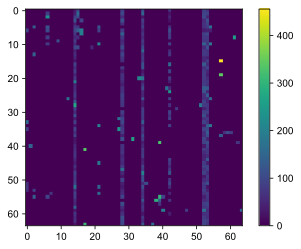

In [4]:
g = dpe.read(0, Tdly=500)
plt.imshow(g * 1e6)
plt.colorbar()

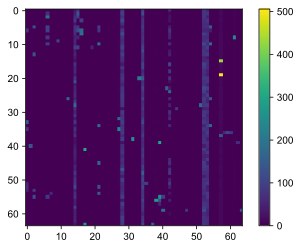

In [5]:
g = dpe.read(0, Tdly=1000, method='fast')
plt.imshow(g * 1e6)
plt.colorbar()

In [25]:
Vset = np.ones((64,64)) * 0.1
Vgate = np.ones((64,64)) * 0.1

Vset[:3,:3] = 0

Vgate[61:,61:] = 0

In [27]:
with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dut = dpe.a0.dut
    dpe.a0.pic_write_batch(Vset, Vgate, mode=0)

In [14]:
#%%
table = [
    [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0],
    [1, 2, 0, 1, 1, 0, 0, 0, 1, 1]
]

ns = [
    [0, 1],
    [1, 0],
    [1, 0],
    [1, 1]
]

from lib_tcam import *

G = gen_tcam_2r(table).T

G = np.concatenate( (G, G, G, G, G, G))

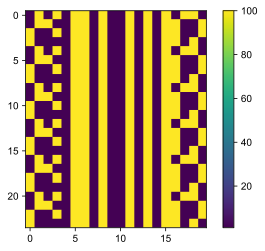

In [15]:
plt.imshow(G*1e6)
plt.colorbar()


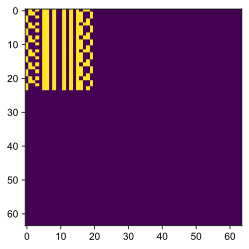

In [16]:
N = 64
targetTolerance = 4e-6

targetG = np.zeros((N,N))
targetG[:G.shape[0], :G.shape[1]] = G

targetGTolerance = np.full((N, N), np.inf)
targetGTolerance[:G.shape[0], :G.shape[1]] = targetTolerance

plt.imshow(targetG)

In [17]:
vSetRamp = np.arange(0.5, 4.4, 0.05)
vGateSetRamp = np.arange(0.5, 1.4, 0.05)
vResetRamp = np.arange(0.3, 1.5, 0.05)
vGateResetRamp = np.arange(5.0, 5.5, 0.5)

maxLoops = 5
array = 0

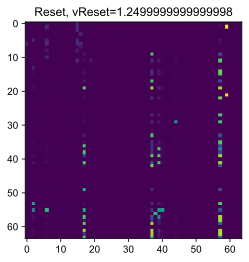

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002373B703DC8> (for post_execute):

In [ ]:
from dut_a0 import *

with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    
    targetGLow = targetG-targetTolerance
    targetGHigh = targetG+targetTolerance
    currentLoops = 0
    zeroMatrix = np.zeros((64,64))
    Vread=0.2
    # Do initial reading
    #GMatrix = pic_read_batch(array, Vread=Vread, gain=-1) / Vread
    input = [0x1<<i for i in range(64)]
    GMatrix = pic_dpe_batch(array, input, gain=-1, Vread=Vread, Tdly=1000) / Vread
    # Now loop as long as any device is out of tolerance for target conductance and we haven't maxed out loops
    while ( (np.any(GMatrix < targetGLow) | np.any(GMatrix > targetGHigh)) & (currentLoops<=maxLoops) ):
        # Do SET operations for any devices too low        
        if np.any(GMatrix < targetGLow):
            print('Now turning ON')
            for vGateSet in vGateSetRamp:
                
                display.clear_output(wait=True)
                plt.imshow(GMatrix)
                plt.title(f'Set, Vgate={vGateSet}')
                display.display(plt.gcf())
                    
                print('Set, Vgate = ', vGateSet)
                for vSet in vSetRamp:
                    vGateSetMatrix = zeroMatrix + vGateSet * (GMatrix < targetGLow)
                    vWriteSetMatrix = zeroMatrix + vSet * (GMatrix < targetGLow)

#                     plt.figure(); plt.imshow(vGateSetMatrix); plt.colorbar()
#                     plt.figure(); plt.imshow(vWriteSetMatrix); plt.colorbar()

#                     assert(1==0)
                    #print('VWrite:', vWriteSetMatrix[0:3,0:3])
                    #print('VGate:', vGateSetMatrix[0:3,0:3])
                    pic_write_batch(vWriteSetMatrix, vGateSetMatrix, array=array, mode=1)
                    #GMatrix = pic_read_batch(array, Vread=Vread, gain=-1) / Vread
                    GMatrix = pic_dpe_batch(array, input, gain=-1, Vread=Vread, Tdly=1000) / Vread
                    
                    
                    if np.all(GMatrix >= targetGLow):
                        break
                if np.all(GMatrix >= targetGLow):
                        break

        # Do RESET operations for any devices too high
        if np.any(GMatrix > targetGHigh):
            print('Now turning OFF')
            for vGateReset in vGateResetRamp:
                print('Reset, Vgate = ', vGateReset)
                for vReset in vResetRamp:
                    vGateResetMatrix = zeroMatrix + vGateReset * (GMatrix > targetGHigh)
                    vWriteResetMatrix = zeroMatrix + vReset * (GMatrix > targetGHigh)
                    pic_write_batch(vWriteResetMatrix, vGateResetMatrix, array=array, mode=0)
                    #GMatrix = pic_read_batch(array, Vread=Vread, gain=-1) / Vread
                    GMatrix = pic_dpe_batch(array, input, gain=-1, Vread=Vread, Tdly=1000) / Vread
                    
                    display.clear_output(wait=True)
                    plt.imshow(GMatrix)
                    plt.title(f'Reset, vReset={vReset}')
                    display.display(plt.gcf())
                    
                    if np.all(GMatrix <= targetGHigh):
                        break
                if np.all(GMatrix <= targetGHigh):
                        break

        currentLoops=currentLoops+1
        print('Current loop = ', currentLoops)
    print('Completed with total loops = ', currentLoops)
#     return GMatrix    


In [4]:
plt.imshow(GMatrix*1e6); plt.colorbar()
# plt.clim(0, 100)

NameError: name 'GMatrix' is not defined

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


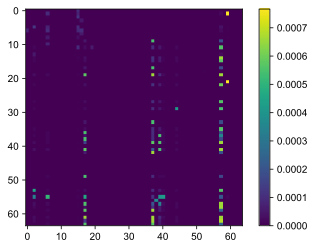

In [77]:
dpe.set_clock(50)

G = dpe.read(0, method='fast', Tdly=1000)
Vwrite = np.zeros((64,64)) 
Vgate = np.zeros((64,64))

plt.figure()
plt.imshow(G);plt.colorbar()

Vwrite[G>500e-6] = 2
Vgate[G>500e-6] = 5

In [109]:
Vwrite = np.zeros((64,64)) + 1.5
Vgate = np.zeros((64,64)) + 5

In [110]:
dpe.set_clock(50)

from dut_a0 import *

with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dpe.a0.pic_write_batch(Vwrite, Vgate, array=1, mode=0, P_RESET=0x0fe)

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
2


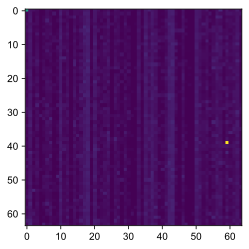

In [111]:
dpe.set_clock(50)

g = dpe.read(1, method='fast')

plt.imshow(g )
print(sum(sum(g>200e-6)))

In [168]:
dpe.set(0, Vset=2, Vgate=1.2)

....

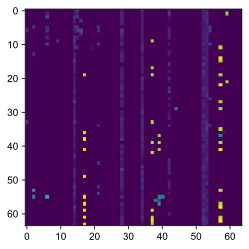

In [180]:
plt.imshow(dpe.read(0))

....

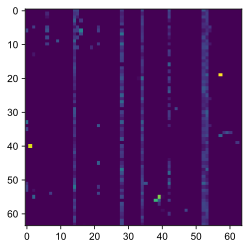

In [10]:
dpe.reset(0, Vreset=1.1, Vgate=5)

plt.imshow(dpe.read(0))

..

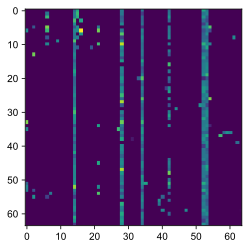

In [19]:
dpe.set(0, Vset=2, Vgate=1)

plt.imshow(dpe.read(0, method='slow', Tdly=500))

..0


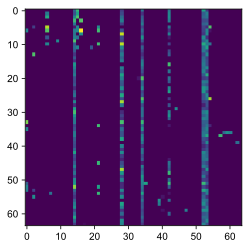

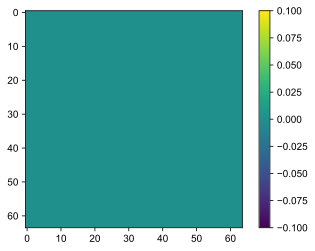

In [18]:
g = dpe.read(0, Tdly=500)
plt.figure()
plt.imshow(g)

Vreset = np.ones((64,64)) * 1.5
Vgate = np.ones((64,64)) * 5.5

Vreset = Vreset * (g>200e-6)
Vgate = Vgate * (g>200e-6)
plt.figure()
plt.imshow(Vreset)
plt.colorbar()

print( sum(g.reshape(-1)>200e-6))

In [15]:
with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dpe.a0.pic_write_batch_ext(Vreset, Vgate, array=0, mode=0, Twidth=1000)

..3677


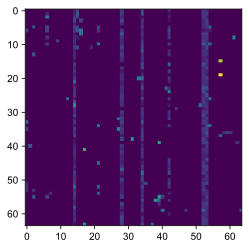

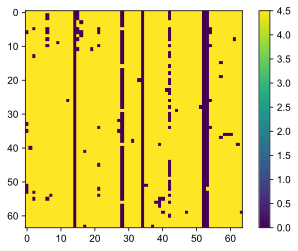

In [274]:
g = dpe.read(0, Tdly=500)
plt.figure()
plt.imshow(g)

Vset = np.ones((64,64)) * 4.5
Vgate = np.ones((64,64)) * 1.5

Vset = Vset * (g<20e-6)
Vgate = Vgate * (g<20e-6)

plt.figure()
plt.imshow(Vset)
plt.colorbar()

print( sum(g.reshape(-1)<20e-6))

In [273]:
with serial.Serial(dpe.ser_name, 9600, timeout=1) as ser:
    dpe.a0.dut.connect(ser)
    dpe.a0.pic_write_batch_ext(Vset, Vgate, array=0, mode=1, Twidth=10000)

.....................................

..0


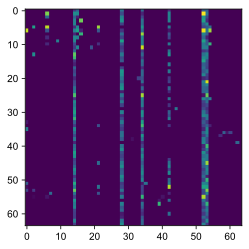

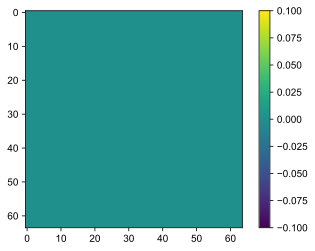

In [153]:
g = dpe.read(0, Tdly=500)
plt.figure()
plt.imshow(g)

Vreset = np.ones((64,64)) * 1.4
Vgate = np.ones((64,64)) * 5.5

Vreset = Vreset * (g>200e-6)
Vgate = Vgate * (g>200e-6)
plt.figure()
plt.imshow(Vreset)
plt.colorbar()

print( sum(g.reshape(-1)>200e-6))

In [152]:
dpe.reset(0, Vreset, Vgate, verbose=True, Twidth=1e-3)

Resetting 1 devices...
Programming with external timing Twidth=1000.0 us


In [118]:
vSetRamp = [0.5, 2.5, 0.5]
vGateSetRamp = [0.5, 1.4, 0.05]
vResetRamp = [0.3, 1.5, 0.05]
vGateResetRamp = [5.0, 5.5, 0.5]

maxSteps = 200
array = 0
shape = [64, 64]

Gtarget = np.ones(shape) * 40e-6
Gtorr = 4e-6

Msel = np.ones(shape)

Ghist = []
vSetHist = []
vGateSetHist = []
vResetHist = []
vResetGateHist = []

vSet = np.zeros(shape) 
vGateSet = np.zeros(shape)
vReset = np.zeros(shape)
vGateReset = np.zeros(shape)

Mset_pre = np.zeros(shape)
Mreset_pre = np.zeros(shape)

Mbound = np.zeros(shape)
maxBound = 3

In [116]:
# vSet = np.zeros(shape) + vSetRamp[0]
# vGateSet = np.zeros(shape) + vGateSetRamp[0]
# vReset = np.zeros(shape) + vResetRamp[0]
# vGateReset = np.zeros(shape) + vGateResetRamp[0]

vSet = np.zeros(shape) 
vGateSet = np.zeros(shape)
vReset = np.zeros(shape)
vGateReset = np.zeros(shape)

Mset_pre = np.zeros(shape)
Mreset_pre = np.zeros(shape)

Mbound = np.zeros(shape)
maxBound = 3

In [112]:
for s in range(maxSteps):
#     Gread = dpe.read(array)
    Ghist.append(Gread)
    
    Mset = ((Gread - Gtarget) < -Gtol) * Msel
    Mreset = ((Gread - Gtarget) > Gtol) * Msel
    
    vSet = vSet * Mset
    vGateSet = vGateSet * Mset
    vReset = vReset * Mreset
    vGateReset = vGateReset * Mreset

#     Pover
    if s != 0:
        # Adjust programming parameters
        for i in range(shape[0]):
            for j in range(shape[1]):
            
                if Mset[i,j] == 1:
                    if Mreset_pre == 1:
                        # Indicates an overshot reset
                        vSet[i,j] = vSetRamp[0]
                        vGateSet[i,j] = vGateSetRamp[0]
                        Mbound[i,j] = 0
                    else:
                        vSet[i,j] += vSetRamp[-1]

                        if vSet[i,j] > vSetRamp[1]:
                            vGateSet[i,j] += vGateSetRamp[-1]

                            if vGateSet[i,j] > vSetRamp[1]:
                                vGateSet[i,j] = vGateSetRamp[1]
                                vSet[i,j] = vSetRamp[1]
                                Mbound[i,j] += 1
                            else:
                                vSet[i,j] = vSetRamp[0]
                        
                    
                if Mreset[i,j] == 1:
                    if Mset_pre == 1:
                        # Indicates an overshot set
                        vReset[i,j] = vResetRamp[0]
                        vGateReset[i,j] = vGateResetRamp[0]
                        Mbound[i,j] = 0
                    else:
                        vReset[i,j] += vResetRamp[-1]

                        if vReset[i,j] > vResetRamp[1]:
                            vGateReset[i,j] += vGateResetRamp[-1]

                            if vGateReset[i,j] > vResetRamp[1]:
                                vGateReset[i,j] = vGateResetRamp[1]
                                vReset[i,j] = vResetRamp[1]
                                Mbound[i,j] += 1
                            else:
                                vSet[i,j] = vSetRamp[0]
                        
    print(f'Start programming, step={s}, maxBound={sum((Mbound>=maxBound).reshape(-1))}')
    # Start programming
    dpe.reset(array, vSet, vGateSet * (Mbound<=maxBound), verbose=True, Twidth=20e-9)
    dpe.set(array, vReset, vGateReset * (Mbound<=maxBound), verbose=True, Twidth=20e-9)
    
    Mset_pre = Mset
    Mreset_pre = Mreset

    break

Start programming, step=0, maxBound=0
Resetting 0 devices...
Programming with internal timing P_RESET=2
Setting 0 devices...
Programming with internal timing P_RESET=2


In [215]:
vSetRamp = [1, 3.5, 1]
vGateSetRamp = [0.5, 1.4, 0.05]
vResetRamp = [0.3, 1.5, 0.05]
vGateResetRamp = [5.0, 5.5, 0.5]

maxSteps = 200
array = 0
shape = [64, 64]

Gtarget = np.ones(shape) * 40e-6
Gtol = 5e-6

Msel = np.ones(shape)

Ghist = []
vSetHist = []
vGateSetHist = []
vResetHist = []
vResetGateHist = []

vSet = np.zeros(shape) 
vGateSet = np.zeros(shape)
vReset = np.zeros(shape)
vGateReset = np.zeros(shape)

Mset_pre = np.zeros(shape)
Mreset_pre = np.zeros(shape)

Mbound = np.zeros(shape)
maxBound = 3

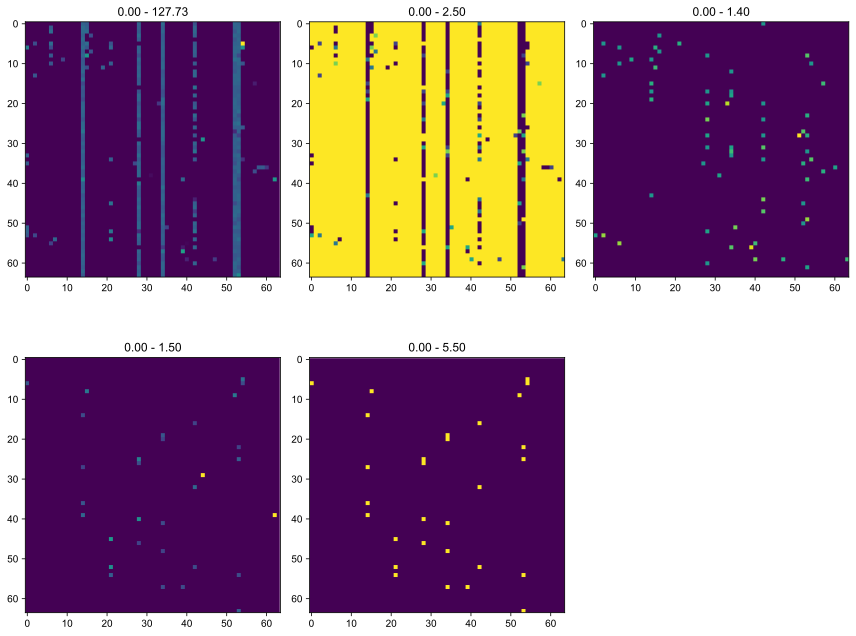

Start programming, step=199, maxBound=3691 succeed= 310
Setting 67 devices...
Programming with external timing Twidth=1000.0000000000001 us
Resetting 29 devices...
Programming with external timing Twidth=1000.0 us


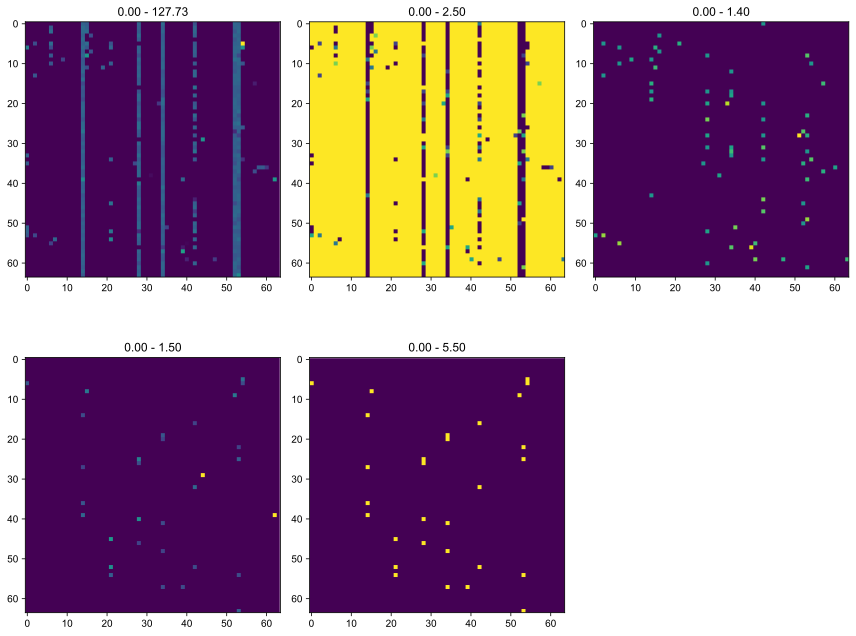

In [216]:
for s in range(maxSteps):
    Gread = dpe.read(array, Tdly=500)
    Ghist.append(Gread)
    
    Mset = ((Gread - Gtarget) < -Gtol) * Msel
    Mreset = ((Gread - Gtarget) > Gtol) * Msel
    
    vSet = vSet * Mset
    vGateSet = vGateSet * Mset
    vReset = vReset * Mreset
    vGateReset = vGateReset * Mreset

#     Pover
        # Adjust programming parameters
    for i in range(shape[0]):
        for j in range(shape[1]):

            if Mset[i,j] == 1:
                if vSet[i,j] == 0 or vGateSet[i,j] == 0:
                    # Initiate
                    vSet[i,j] = vSetRamp[0]
                    vGateSet[i,j] = vGateSetRamp[0]
                    Mbound[i,j] = 0
                else:
                    vSet[i,j] += vSetRamp[-1]

                    if vSet[i,j] > vSetRamp[1]:
                        vGateSet[i,j] += vGateSetRamp[-1]

                        if vGateSet[i,j] > vGateSetRamp[1]:
                            vGateSet[i,j] = vGateSetRamp[1]
                            vSet[i,j] = vSetRamp[1]
                            Mbound[i,j] += 1
                        else:
                            vSet[i,j] = vSetRamp[0]


            if Mreset[i,j] == 1:
                if vReset[i,j] == 0 or vGateReset[i,j] == 0:
                    # Initiate
                    vReset[i,j] = vResetRamp[0]
                    vGateReset[i,j] = vGateResetRamp[0]
                    Mbound[i,j] = 0
                else:
                    vReset[i,j] += vResetRamp[-1]

                    if vReset[i,j] > vResetRamp[1]:
                        vGateReset[i,j] += vGateResetRamp[-1]

                        if vGateReset[i,j] > vGateResetRamp[1]:
                            vGateReset[i,j] = vGateResetRamp[1]
                            vReset[i,j] = vResetRamp[1]
                            Mbound[i,j] += 1
                        else:
                            vReset[i,j] = vSetRamp[0]
                        
    vSetHist.append(vSet)
    vGateSetHist.append(vGateSet * (Mbound<=maxBound))
    vResetHist.append(vReset)
    vResetGateHist.append(vGateReset * (Mbound<=maxBound))
    
    plt.figure(1, figsize=(12,10))
    plt.subplot(2,3,1)
    plt.imshow(Gread * 1e6)
    plt.title(f'{Gread.min()*1e6:.2f} - {Gread.max()*1e6:.2f}')
    
    plt.subplot(2,3,2)
    plt.imshow(vSet)
    plt.title(f'{vSet.min():.2f} - {vSet.max():.2f}')
    
    plt.subplot(2,3,3)
    plt.imshow(vGateSet * (Mbound<=maxBound))
    plt.title(f'{vGateSet.min():.2f} - {vGateSet.max():.2f}')
    
    plt.subplot(2,3,4)
    plt.imshow(vReset)
    plt.title(f'{vReset.min():.2f} - {vReset.max():.2f}')
    
    plt.subplot(2,3,5)
    plt.imshow(vGateReset * (Mbound<=maxBound))
    plt.title(f'{vGateReset.min():.2f} - {vGateReset.max():.2f}')
    
    plt.tight_layout()
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

    print(f'Start programming, step={s}, maxBound={sum((Mbound>=maxBound).reshape(-1))} ' +
          f'succeed= {sum( (np.abs(Gread-Gtarget)<Gtol).reshape(-1))}')
    
    # Start programming
    dpe.set(array, vSet, vGateSet * (Mbound<=maxBound), verbose=True, Twidth=1e-3)
    dpe.reset(array, vReset, vGateReset * (Mbound<=maxBound), verbose=True, Twidth=1e-3)

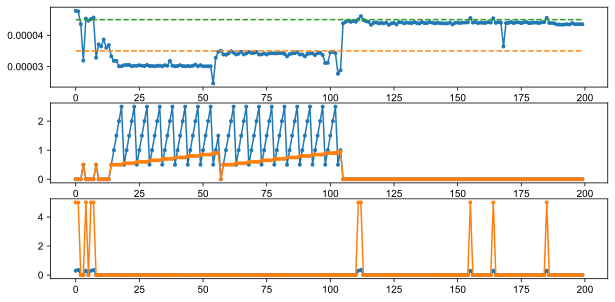

In [222]:
vSetHist = np.array(vSetHist)
vGateSetHist = np.array(vGateSetHist)

Ghist = np.array(Ghist)
vResetHist = np.array(vResetHist)
vResetGateHist = np.array(vResetGateHist)


x = 25
y = 52

plt.figure(figsize=(10,5))
plt.subplot(311)
plt.plot(Ghist[:, x, y], '.-')
plt.plot([0, len(Ghist[:, x, y])-1], [Gtarget[x,y]-Gtol, Gtarget[x,y]-Gtol], '--')
plt.plot([0, len(Ghist[:, x, y])-1], [Gtarget[x,y]+Gtol, Gtarget[x,y]+Gtol], '--')

plt.subplot(312)
plt.plot(vSetHist[:, x, y], '.-')
plt.plot(vGateSetHist[:, x, y], '.-')
plt.subplot(313)
plt.plot(vResetHist[:, x, y], '.-')
plt.plot(vResetGateHist[:, x, y], '.-')

In [217]:
from lib_data import *
save_workspace(vars(), note='prog_array0')

Saving In(<class 'list'>), Out(<class 'dict'>), a(<class 'numpy.ndarray'>), Twidth(<class 'float'>), g(<class 'numpy.ndarray'>), Vreset(<class 'numpy.ndarray'>), Vgate(<class 'numpy.ndarray'>), vSetRamp(<class 'list'>), vGateSetRamp(<class 'list'>), vResetRamp(<class 'list'>), vGateResetRamp(<class 'list'>), maxLoops(<class 'int'>), array(<class 'int'>), maxSteps(<class 'int'>), s(<class 'int'>), shape(<class 'list'>), Ginit(<class 'numpy.ndarray'>), Gtarget(<class 'numpy.ndarray'>), Ghist(<class 'list'>), Gcurr(<class 'numpy.ndarray'>), Gerror(<class 'numpy.ndarray'>), Msel(<class 'numpy.ndarray'>), Gtorr(<class 'float'>), Mprog(<class 'numpy.ndarray'>), Mreset(<class 'numpy.ndarray'>), Mset(<class 'numpy.ndarray'>), Gread(<class 'numpy.ndarray'>), vSetPt(<class 'numpy.ndarray'>), vGateSetPt(<class 'numpy.ndarray'>), vResetPt(<class 'numpy.ndarray'>), vGateResetPt(<class 'numpy.ndarray'>), vSet(<class 'numpy.ndarray'>), vGateSet(<class 'numpy.ndarray'>), vReset(<class 'numpy.ndarray'>

In [202]:
load_workspace(vars(), '20191209-165345-prog_array0')

Loaded: In, Out, a, Twidth, g, Vreset, Vgate, vSetRamp, vGateSetRamp, vResetRamp, vGateResetRamp, maxLoops, array, maxSteps, s, shape, Ginit, Gtarget, Ghist, Gcurr, Gerror, Msel, Gtorr, Mprog, Mreset, Mset, Gread, vSetPt, vGateSetPt, vResetPt, vGateResetPt, vSet, vGateSet, vReset, vGateReset, Mset_pre, Mreset_pre, Mbound, maxBound, i, j, vSetHist, vGateSetHist, vResetHist, vResetGateHist, x, y, 


(array([  3.,   5.,   3.,   7.,   8.,  37., 106.,  33.,  19.,  22.,  29.,
         22.,  31.,  20.,  16.,  12.,   3.,   1.,   3.,   2.,   0.,   0.,
          1.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   2.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]), array([  3.83186706,   9.40449658,  14.9771261 ,  20.54975562,
         26.12238514,  31.69501466,  37.26764418,  42.8402737 ,
         48.41290323,  53.98553275,  59.55816227,  65.13079179,
         70.70342131,  76.27605083,  81.84868035,  87.42130987,
         92.99393939,  98.56656891, 104.13919844, 109.71182796,

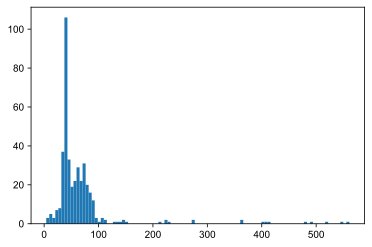

In [206]:
# Gtmp = Gread
# Gtmp[Gtmp<2e-6] = np.nan

plt.hist(Gread[Gread>2e-6].reshape(-1)*1e6, 100)